# Installing packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
filePath= '/content/drive/MyDrive/' # change this

Mounted at /content/drive


In [ ]:
import gzip
import json
import pandas as pd
import random
import numpy as np
import torch
import warnings
import re
import itertools
import operator
import pickle
import csv
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from nltk.util import bigrams
from html import unescape
from string import punctuation
from sklearn.feature_extraction import _stop_words
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
!pip install feather-format
import feather

In [ ]:
! pip install gender-guesser
import gender_guesser.detector as gender

     |████████████████████████████████| 379 kB 5.3 MB/s eta 0:00:01


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 5.3 MB/s eta 0:00:01


# Loading the Amazon book dataset
This section loads the meta book dataset and extracts the reviews for the selected books. The following steps were taken:
- Load meta data for books
- Extract the books for the categories of interest: *classic, romance* and *science fiction*
- Remove book duplicates and children books from the meta dataset
- Load the reviews that correspond to the selected books and store them in a separate file


In [ ]:
# Loading the books meta dataset
meta_data = []
with open('meta_Books.json', 'r') as f:
    for l in f:
        obj = json.loads(l)
        meta_data.append(obj)

In [ ]:
len(meta_data)

2934949

In [ ]:
meta_data[1]

{'category': ['Books',
  'New, Used & Rental Textbooks',
  'Medicine & Health Sciences'],
 'tech1': '',
 'description': [],
 'fit': '',
 'title': 'Mksap 16 Audio Companion: Medical Knowledge Self-Assessment Program',
 'also_buy': [],
 'tech2': '',
 'brand': 'Acp',
 'feature': [],
 'rank': '1,702,625 in Books (',
 'also_view': ['B01MUCYEV7', 'B01KUGTY6O'],
 'main_cat': 'Books',
 'similar_item': '',
 'date': '',
 'price': '',
 'asin': '000047715X',
 'imageURL': [],
 'imageURLHighRes': []}

In [ ]:
# Extracting relevant categories
relevant_categories = ["Romance", "Romantic Suspense", "Romantic Commedy",
                       "Science Fiction", "Science Fiction &amp; Dystopian",
                       "Classics"]

relevant_data = dict()

for cat in relevant_categories:
    for i,item in enumerate(meta_data):
        if cat in meta_data[i]['category']:
                relevant_data[i]= item

In [ ]:
# Store relevant books as dataframe
df_all = pd.DataFrame.from_dict(relevant_data, orient="index")

In [ ]:
len(df_all)

91986

In [ ]:
# Remove book duplicates
df_all_pure=df_all.drop_duplicates(subset = 'asin', ignore_index=True)

In [ ]:
len(df_all_pure)

91941

In [ ]:
df_all_pure.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Books, Romance, Historical]",,[],,Kirkland Revels,"[0385006098, 0385065884, 0385082762, 038512281...",,Visit Amazon's Victoria Holt Page,[],"2,210,538 in Books (","[0449452522, 0385082762]",Books,,,$11.99,0002214032,[],[],NaN
1,"[Books, Romance, Historical]",,[hardbound],,The Lynmara Legacy,"[0006161340, 0380651513, 0002216639, 038513468...",,Visit Amazon's Catherine Gaskin Page,[],"4,606,839 in Books (",[0002216639],Books,,,$6.66,0002214962,[],[],NaN
2,"[Books, Romance]",,[],,Smouldering Fire,"[0006135196, 0030426162, 0030665558, 140227082...",,Visit Amazon's D. E. Stevenson Page,[],"8,260,431 in Books (","[1492607398, 1912574519, 1912574535, 191257457...",Books,,,$87.75,0002217600,[],[],NaN
3,"[Books, Romance, Historical]",,[],,The Property of a Gentleman,"[0006164625, B000BSIFO4, B0007EISXA, 038065151...",,Visit Amazon's Catherine Gaskin Page,[],"4,665,082 in Books (","[B002J4F7VC, 0449236900, 0002214962]",Books,,,$25.53,0002216639,[],[],NaN
4,"[Books, Romance, Historical]",,"[Ginny Tilsit...Lively, attractive, she had be...",,The Tilsit Inheritance,"[000221203X, 0002212269, 0002216639, 000616593...",,Visit Amazon's Catherine Gaskin Page,[],"5,164,872 in Books (","[0385134681, 0006161340, 038070174X, 044923690...",Books,,,$5.39,0002218100,[],[],NaN


In [ ]:
# Exclude children's books
df_adults = df_all_pure[~df_all_pure.category.astype(str).str.contains('Children')]

# Exclude books of categories which combine romance and science fiction labels ...
# ... because they mix women and men typcial categories
df_adults = df_adults[~((df_adults['category'].astype(str).str.contains('Romance'))
                      & (df_adults['category'].astype(str).str.contains('Science Fiction')))]

In [ ]:
len(df_adults)

90367

In [ ]:
# Store dataframe
df_adults.to_pickle("df_adults.pkl")

# Store unique book IDs of selected books
unique_products = list(df_adults['asin'])

In [ ]:
# Extracting all reviews of the selected books
pattern = re.compile(rb'(?<=asin\":\s\")\d*(?=\")')
with open('selection_books.json', 'w') as outfile:
    with gzip.open("Books.json.gz", "r") as my_file:
        while True:
            line = list(itertools.islice(my_file, 100000))
            if line:
                for l in line:
                    match = re.search(pattern, l)
                    if match:
                        if str(match[0],'utf-8') in unique_products:
                            outfile.write(str(l, 'utf-8'))
            else:
                break

# Preparing the final reviews dataset
This section prepares the final dataset. Steps included are:
- Data preprocessing
- Defining how to predict the gender based on usernames
- Once again narrow down book categories (because otherwise dataset would have been to large)
- Applying cleaning functions to reviews and obtain gender predictions
- Deleting reviews with less than 10 words
- Splitting dataset in training, developement and test set


## Stop words, embeddings and cleaning functions

In [ ]:
# Loading stop words (previously provided stopwords and sklearn stopwords)
stops_1 = list()

with open(filePath+'stopwords_formative2.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in fd:
        stops_1.append(row.replace("\n",""))

stops_2 = list(_stop_words.ENGLISH_STOP_WORDS) + ['t', 's', 'S']
len(stops_2)

321

In [ ]:
# Combine both stop lists and extract unique words
stops_1.extend(stops_2)

stops = set(stops_1)
len(stops)

382

In [ ]:
# Load fastText word embeddings
with open(filePath+'fasttext_vectors.p', 'rb') as f:
    fasttext_vecs = pickle.load(f)

In [ ]:
# Tokenise words for being able to count words in original review
# (used later for deleting reviews with less than 10 words)
def tokenise(text):
    text = re.sub("[^a-zA-Z0-9]", ' ', text)
    return [w.lower() for w in text.split()]

In [ ]:
# Cleaning function used to prepare review texts for LSTM
def cleaning(text):
    text = re.sub("&nbsp;<a.*?</a>|<a.*?</a>", 'url', text)
    text = text.replace('\n',' ')
    text = text.replace('\t',' ')
    text = re.sub("[^a-zA-Z0-9']", ' ', text)
    text = [w.lower() for w in text.strip().split()]
    return [w for w in text if w in fasttext_vecs]

In [ ]:
# Cleaning function used to prepare review texts for Naive Bayes and descriptive analyses
def cleaning_for_descriptives(text):
    text = re.sub("&nbsp;<a.*?</a>|<a.*?</a>", 'url', text) # replace urls in review with 'url'
    text = text.replace('\n',' ')
    text = text.replace('\t',' ')
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    return [w.lower() for w in text.strip().split() if w.lower() not in stops and w.lower() in fasttext_vecs]

*Rationale for determining gender*:
- If a username consists of less than three name parts, predict gender based on the first part
- If a username has three parts or more, extract the first three parts, predict the gender for all parts and determine that if one of the parts is female, the gender is set to female. If there is no female part but a male one, the gender is set to male. This approach is based on the observation that some users abbreviate their first name but use a gender-revealing middle name(s).
- All predictions of the gender-guesser which are NOT female or male are set to "none"

In [ ]:
# Determine function with predicts gender based on username

# Loading gender guesser
d = gender.Detector(case_sensitive=False)

def prepare_gender_guesser(names):

    # Splittin usernames and lowering letters
    name = [n.lower() for n in names.split()]

    # Determine gender for usernames with more than or equal to three parts
    if len(name) >= 3:
        new_name_list = name[:2]
        gender_pred = [d.get_gender(i) for i in new_name_list ]
        if 'female' in gender_pred:
            return 'female'
        elif 'male' in gender_pred:
            return 'male'
        else:
            return 'none'

    # Determining gender for usernames with less than three parts
    elif len(name) < 3 and len(name) > 0:
        first_name = d.get_gender(name[0])
        if first_name == 'female':
            return first_name
        elif first_name == 'male':
            return first_name
        else:
            first_name = 'none'
            return first_name
    else:
        first_name = 'none'
        return first_name



## Further narrowing down of the book genres and obtaining the final preprocessed dataset

In [ ]:
# For romance genre reduce to category "romance contemporary"
# For science fiction genre reduce to "Science Fiction &amp; Fantasy"
# (both of them are the biggest categories within the genres)

df_reduced = df_adults[((df_adults['category'].astype(str).str.contains('Classic'))
                        | ((df_adults['category'].astype(str).str.contains('Science Fiction'))
                      & (df_adults['category'].astype(str).str.contains('&amp')))
                        |  (df_adults['category'].astype(str).str.contains('Contemporary')))
                       & ~((df_adults['category'].astype(str).str.contains('Teen'))
                           | (df_adults['category'].astype(str).str.contains('Bible'))
                           | (df_adults['category'].astype(str).str.contains('Anthologies'))
                           | (df_adults['category'].astype(str).str.contains('Space'))
                           | (df_adults['category'].astype(str).str.contains('Short Stories')))]

# Customise the category labels
df_reduced.loc[df_reduced['category'].astype(str).str.contains('Romance'), 'label'] = 'romance'
df_reduced.loc[df_reduced['category'].astype(str).str.contains('Classic'), 'label'] = 'classic'
df_reduced.loc[df_reduced['category'].astype(str).str.contains('Science'), 'label'] = 'science_fiction'

df_reduced.head()

,index,category,tech1,description,fit,title,also_buy,tech2,brand,feature,...,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,screen,label
18,18,"[Books, Romance, Contemporary]",,[A classic tale from Helen Forrester set in th...,,The Moneylenders of Shahpur,[],,Visit Amazon's Helen Forrester Page,[],...,Books,,,$17.16,0006173543,[],[],NaN,False,romance
21,21,"[Books, Romance, Contemporary]",,[Reissue of the author's most famous and well-...,,Scandalous Risks,"[0006496911, 0006496873, 000649692X, 044922555...",,Visit Amazon's Susan Howatch Page,[],...,Books,,,$24.73,0006496903,[],[],NaN,False,romance
22,22,"[Books, Romance, Contemporary]",,[A newly reissued edition of Agatha Christie's...,,Absent in the Spring,"[0008131473, 0312274726, 0062093703, 000649945...",,Visit Amazon's Agatha Christie Page,[],...,Books,,,$20.10,0006499473,[],[],NaN,False,romance
23,23,"[Books, Romance, Contemporary]",,"[443pages. 18,1x10,9x3,2cm. Broch.]",,Three Weeks in Paris,"[0440295939, 0385492758, 0061008109, 000725233...",,Visit Amazon's Barbara Taylor Bradford Page,[],...,Books,,,$14.30,0006514405,[],[],NaN,False,romance
28,28,"[Books, Romance, Contemporary]",,[Thirty-year-old Serena Stone is a talented wa...,,Secrets from the Past,"[1568959656, 0312631693, 1250032377, 125009128...",,,[],...,Books,,,$19.38,000730417X,[],[],NaN,False,romance


In [ ]:
df_reduced['label'].value_counts()

romance            24337
science_fiction    19381
classic             5624
Name: label, dtype: int64

In [ ]:
# Load preselected book reviews
i = 0
review_data = []
with open(filePath+'selection_books.json', 'r') as f:
    for l in f:
            obj = json.loads(l)
            review_data.append(obj)

len(review_data)

3530764

In [ ]:
# Create list of final relevant book IDs
relevant_asin = list(df_reduced['asin'])

# Delete variables that are not of interest to this study
delete_keys = ['overall', 'vote', 'verified', 'style', 'summary',
 'unixReviewTime', 'image']

In [ ]:
# Predict gender and create genre-gender labels

numer_undetermined_gender = 0

for i in range(len(review_data)):

    # Store book id
    ident = review_data[i]['asin']
    if (ident in relevant_asin) and ('reviewerName' in review_data[i]) and (review_data[i]['reviewerName']) \
    and ('reviewText' in review_data[i]):

        # Predict gender
        review_data[i]['gender_pred']= prepare_gender_guesser(review_data[i]['reviewerName'])
        if review_data[i]['gender_pred']== 'none':
            numer_undetermined_gender +=1
        elif review_data[i]['gender_pred']!= 'none':

            # Apply clearning functions
            review_data[i]['tokenised']=tokenise(review_data[i]['reviewText'])
            review_data[i]['cleaned_text']=cleaning(review_data[i]['reviewText'])
            review_data[i]['without_stops']= cleaning_for_descriptives(review_data[i]['reviewText'])

            # Store book genre and gender to create label
            cat = df_reduced.loc[df_reduced['asin']== ident, 'label'].iloc[0]
            gen = review_data[i]['gender_pred']
            review_data[i]['true_label'] = cat + '_' + gen

In [ ]:
print('The number of usernames for which gender could not be identified is: {}.'.format(numer_undetermined_gender))
print('\nThese are {}% of all reviews.'.format(round(100*(numer_undetermined_gender/len(review_data)), 2)))

The number of usernames for which gender could not be identified is: 1092337.

These are 30.94% of all reviews.


In [ ]:
# Create reviews dataframe
df_uncleaned_reviews = pd.DataFrame.from_dict(review_data)

# Get dataset with all reviews which have gender predicted
df_reviews_cleaned = df_uncleaned_reviews[(df_uncleaned_reviews.gender_pred != 'none')
                                          & (df_uncleaned_reviews.gender_pred.notna())]

# Remove irrelevant variables
df_reviews_cleaned = df_reviews_cleaned.drop(delete_keys, axis=1)


In [ ]:
# Create label id column for LSTM later
label2id = {'classic_female': 0, 'classic_male': 1, 'romance_female': 2,
            'romance_male': 3, 'science_fiction_female': 4, 'science_fiction_male': 5}

df_reviews_cleaned['label_id'] = df_reviews_cleaned['true_label'].map(label2id)

df_reviews_cleaned.head()

,reviewTime,reviewerID,asin,reviewerName,reviewText,gender_pred,tokenised,cleaned_text,without_stops,true_label,vec_rep_without_stops,label_id
587,"04 28, 1998",AGHIV0V0ON7MO,0002051850,David Graham,I happen to think Hemingway is one of the most...,male,"[i, happen, to, think, hemingway, is, one, of,...","[i, happen, to, think, is, one, of, the, most,...","[happen, think, 20th, century, particular, boo...",classic_male,"[-0.028970389, 0.025170958, 0.01835015, 0.0587...",1
589,"02 8, 1998",ATOFFO1VNCAGQ,0002051850,Michael Delaware,Hemmingway touched my heart as a reader in a w...,male,"[hemmingway, touched, my, heart, as, a, reader...","[touched, my, heart, as, a, reader, in, a, way...","[touched, heart, reader, way, author, words, k...",classic_male,"[-0.01345888, 0.010416696, 0.055723477, 0.0768...",1
592,"03 17, 2018",A280CJJDAE7K5D,0002051850,Tristan Bell,good,male,[good],[good],[good],classic_male,"[-0.09213716, -0.0634383, 0.0017381323, 0.1352...",1
593,"03 14, 2018",A26P7AP0KTYHDK,0002051850,Barbie,The font is practically unreadable. The book ...,female,"[the, font, is, practically, unreadable, the, ...","[the, font, is, practically, the, book, itself...","[font, practically, book, looks, like, cheap, ...",classic_female,"[-0.008910524, 0.06032888, 0.006115631, 0.0627...",0
594,"03 13, 2018",A1VLYX64G3F25W,0002051850,Joe,Terrible kindle edition of a great book! Cont...,male,"[terrible, kindle, edition, of, a, great, book...","[terrible, kindle, edition, of, a, great, book...","[terrible, kindle, edition, great, book, conte...",classic_male,"[-0.018616777, 0.053754397, -0.019188967, 0.04...",1


In [ ]:
# Remove reviews with less than 10 words
def count_words(word_list):
    return len(word_list)

df_reviews_sentences = df_reviews_cleaned[df_reviews_cleaned['tokenised'].map(lambda x: count_words(x) >9)]
print('{}% of the reviews have less than 10 words. \
      I will remove them.'.format(round((1-(len(df_reviews_sentences)/len(df_reviews_cleaned)))*100, 2)))

10.79% of the reviews have less than 10 words. I will remove them.


In [ ]:
# Store unique categories of the final dataset
categories = list(df_reviews_cleaned.true_label.unique())
categories

['classic_male',
 'classic_female',
 'romance_male',
 'romance_female',
 'science_fiction_male',
 'science_fiction_female']

In [ ]:
# Train, developement, test split based on group shuffle split to avoid information leakage

train_data = pd.DataFrame()
dev_test_data = pd.DataFrame()
dev_data = pd.DataFrame()
test_data = pd.DataFrame()

# Group shuffle split
gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
# Note: test_size here means the proportion of groups which should exclusively be in the test set
gs_dev_test = GroupShuffleSplit(n_splits=2, test_size=.5, random_state=0)

for cat in categories:
    train_index, dev_test_index = next(gs.split(df_reviews_sentences[df_reviews_sentences.true_label == cat],
                                                groups=df_reviews_sentences[df_reviews_sentences.true_label == cat].asin))
    train = df_reviews_sentences[df_reviews_sentences.true_label == cat].iloc[train_index]
    dev_test = df_reviews_sentences[df_reviews_sentences.true_label == cat].iloc[dev_test_index]
    train_data = train_data.append(train)
    dev_test_data=dev_test_data.append(dev_test)

    # Split of dev_test_data into dev_data and test_data:
    dev_index, test_index = next(gs_dev_test.split(dev_test[dev_test.true_label==cat],
                                                   groups=dev_test[dev_test.true_label==cat].asin))
    dev = dev_test[dev_test.true_label==cat].iloc[dev_index]
    test = dev_test[dev_test.true_label==cat].iloc[test_index]
    dev_data = dev_data.append(dev)
    test_data = test_data.append(test)

In [ ]:
print(len(df_reviews_sentences))
print(len(train_data))
print(len(dev_data))
print(len(test_data))

767860
617235
75061
75564


In [ ]:
train_data.head()

,index,reviewTime,reviewerID,asin,reviewerName,reviewText,gender_pred,tokenised,cleaned_text,without_stops,true_label,vec_rep_without_stops,label_id
2,593,"03 14, 2018",A26P7AP0KTYHDK,0002051850,Barbie,The font is practically unreadable. The book ...,female,"[the, font, is, practically, unreadable, the, ...","[the, font, is, practically, the, book, itself...","[font, practically, book, looks, like, cheap, ...",classic_female,"[-0.008910524, 0.06032888, 0.006115631, 0.0627...",0
4,595,"03 12, 2018",AZ0EQP975Q8EF,0002051850,Sarah C. Frederick,This book sold me on Ernest Hemingway! I like ...,female,"[this, book, sold, me, on, ernest, hemingway, ...","[this, book, sold, me, on, i, like, his, easy,...","[book, sold, like, easy, read, short, sentence...",classic_female,"[-0.007825832, 0.016489625, 0.0075740465, 0.06...",0
13,618,"11 20, 2017",A33H24SI5QIVX,0002051850,Heidi PDX booklover,I personally found this book way too long and ...,female,"[i, personally, found, this, book, way, too, l...","[i, personally, found, this, book, way, too, l...","[personally, book, way, long, slow, moving, re...",classic_female,"[-0.011763638, 0.024976425, 0.006988768, 0.064...",0
18,627,"10 8, 2017",A2JSJ5KL5MOUMA,0002051850,Anita L. Fretwell,I found it somewhat difficult to follow and it...,female,"[i, found, it, somewhat, difficult, to, follow...","[i, found, it, somewhat, difficult, to, follow...","[somewhat, difficult, follow, engaging]",classic_female,"[-0.026339412, -0.014321494, 0.007421734, 0.07...",0
20,633,"09 12, 2017",A1SWDPBA57PC6Z,0002051850,Zaruhi Vardanyan,This is an abridged version which was not clea...,female,"[this, is, an, abridged, version, which, was, ...","[this, is, an, abridged, version, which, was, ...","[abridged, version, clear, buying, poorly, wri...",classic_female,"[-0.036207855, 0.009188338, 0.004144261, 0.066...",0


# Descriptive analyses of the dataset
This section explores the dataset and prepares the vocabulary for the NB classifier. Steps include:
- Obtaining information about number of reviews and distribution of labels
- Extracting word unigrams and their frequency from the training dataset
- Calculating Jaccard similarities of the classes

## Information about the dataset

In [ ]:
# Length of entire dataset
print('In total, I am considering {} reviews.'.format(len(df_reviews_sentences)))

# Distribution of lables in the entire dataset
dict_plot_cat = dict()
for cat in categories:
    dict_plot_cat[cat]=len(df_reviews_sentences[df_reviews_sentences.true_label==cat])/len(df_reviews_sentences)

In total, I am considering 767860 reviews.


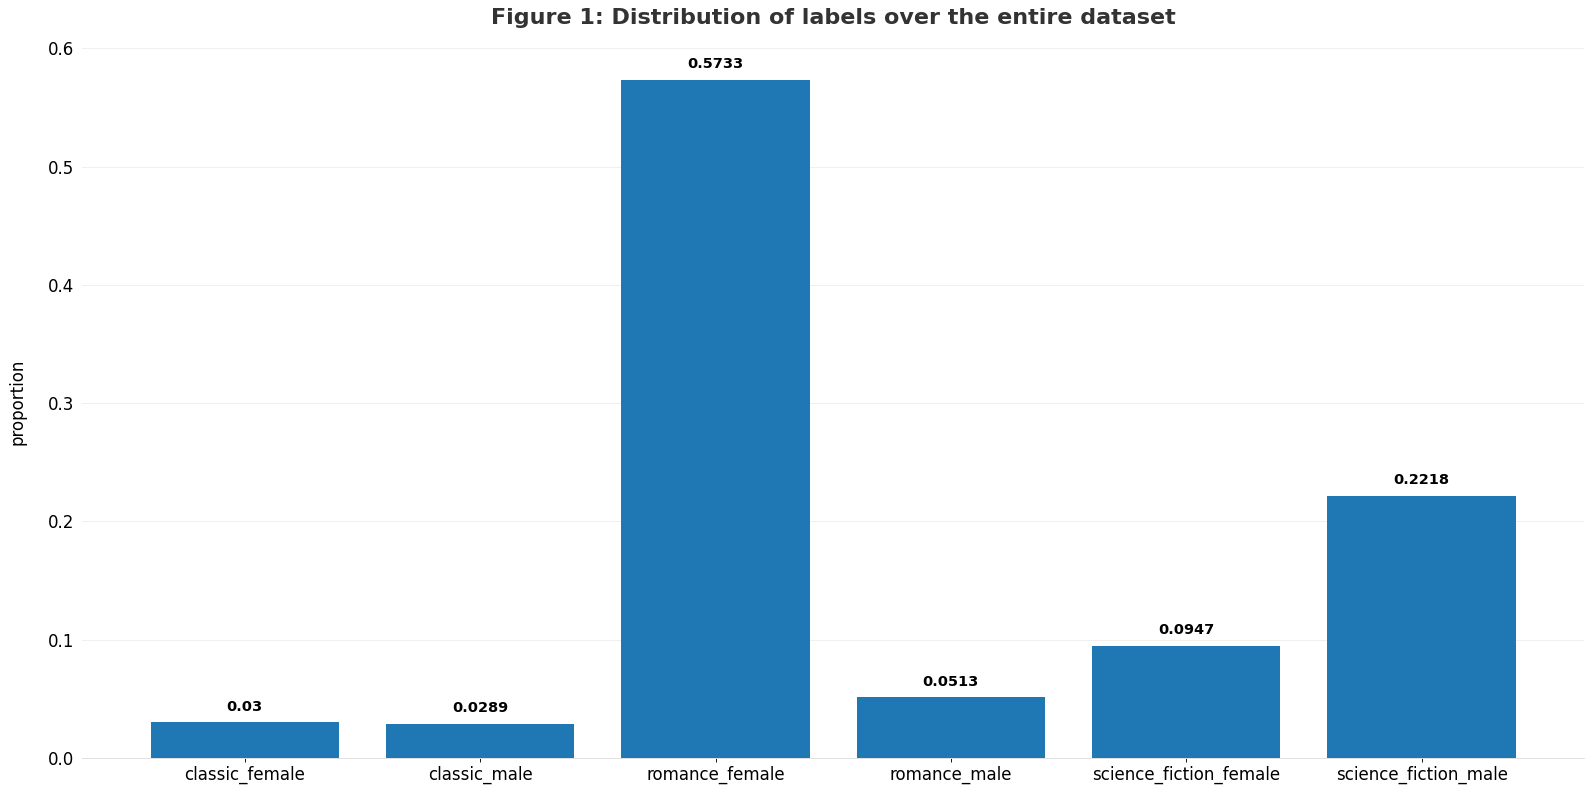

In [ ]:
# Labels distribution plot
fig,ax = plt.subplots(figsize=(20,10), dpi=80)

bar_chart = ax.bar(x=list(dict_plot_cat.keys()),
       height = list(dict_plot_cat.values()))

# Axes formatting and labelling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=True, left=False, labelsize=15)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_ylabel('proportion', labelpad=20, fontsize=15)
ax.set_title('Figure 1: Distribution of labels over the entire dataset', pad=20, fontsize=20,
             color='#333333', weight='bold')

for bar in bar_chart:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 4),
      horizontalalignment='center',
      #color=bar_color,
      color = 'black',
      weight='bold',
      size = 13)

plt.tight_layout()
plt.savefig(filePath+'distribution_labels.pdf', format ='pdf')

In [ ]:
# Length of the test dataset
print('The length of the test dataset is: {}'.format(len(test_data)))

# Number of females and males in the test dataset
sum_females = len(test_data[test_data.true_label.str.contains('female')])

# Percentage women in the test dataset
print('The percentage of women in the dataset is: {}%'.format(round(sum_females/len(test_data),4)*100))

# Percentage categories in the test dataset
sum_classic = len(test_data[test_data.true_label.str.contains('classic')])
sum_romance = len(test_data[test_data.true_label.str.contains('romance')])
sum_science = len(test_data[test_data.true_label.str.contains('science')])
print('The fraction of classic reviews in the dataset is: {}%'.format(round(sum_classic/len(test_data),2)*100))
print('The fraction of romance reviews in the dataset is: {}%'.format(round(sum_romance/len(test_data),2)*100))
print('The fraction of science reviews in the dataset is: {}%'.format(round(sum_science/len(test_data),2)*100))

The length of the test dataset is: 75564
The percentage of women in the dataset is: 70.0%
The fraction of classic reviews in the dataset is: 6.0%
The fraction of romance reviews in the dataset is: 61.0%
The fraction of science reviews in the dataset is: 33.0%


## Create vocabulary and calculate Jaccard similarities

In [ ]:
# Initialise data structure for vocabulary dict (inspired by solutions formative 4)
vocab_unigrams = defaultdict(Counter)

# Create vocabulary
for i,j in zip(train_data.without_stops, train_data.true_label):
    vocab_unigrams[j].update(i)

# Inspect most frequent unigrams
for l in categories:
    print(f'The 30 most frequent unigrams in {l.upper()} books:', vocab_unigrams[l].most_common(30))

The 30 most frequent unigrams in CLASSIC_FEMALE books: [('book', 20013), ('read', 13436), ('story', 8201), ('love', 6139), ('like', 4907), ('time', 4689), ('reading', 4651), ('novel', 4439), ('characters', 4280), ('good', 3809), ('books', 3696), ('great', 3619), ('life', 3456), ('really', 3150), ('way', 2503), ('people', 2451), ('written', 2336), ('character', 2294), ('classic', 2196), ('think', 2042), ('know', 1846), ('enjoyed', 1837), ('recommend', 1817), ('years', 1807), ('writing', 1750), ('little', 1740), ('author', 1655), ('world', 1649), ('end', 1631), ('reader', 1613)]
The 30 most frequent unigrams in CLASSIC_MALE books: [('book', 22615), ('read', 14074), ('story', 8355), ('novel', 7838), ('like', 6555), ('time', 6532), ('great', 5152), ('life', 5144), ('good', 4943), ('reading', 4894), ('characters', 4693), ('world', 4657), ('books', 4136), ('people', 4004), ('man', 3499), ('way', 3403), ('love', 3219), ('written', 3067), ('really', 3047), ('work', 2999), ('character', 2937), 

In [ ]:
# Get number of unigrams for each label in the training data
list_number_of_unigrams = list()
print('Number of unigrams:')
for c_i in categories:
    print(f"{c_i.upper()}:\t {len(vocab_unigrams[c_i])} entries")
    list_number_of_unigrams.append(len(vocab_unigrams[c_i]))

Number of unigrams:
CLASSIC_FEMALE:	 11822 entries
CLASSIC_MALE:	 14502 entries
ROMANCE_FEMALE:	 16837 entries
ROMANCE_MALE:	 12441 entries
SCIENCE_FICTION_FEMALE:	 15600 entries
SCIENCE_FICTION_MALE:	 18828 entries


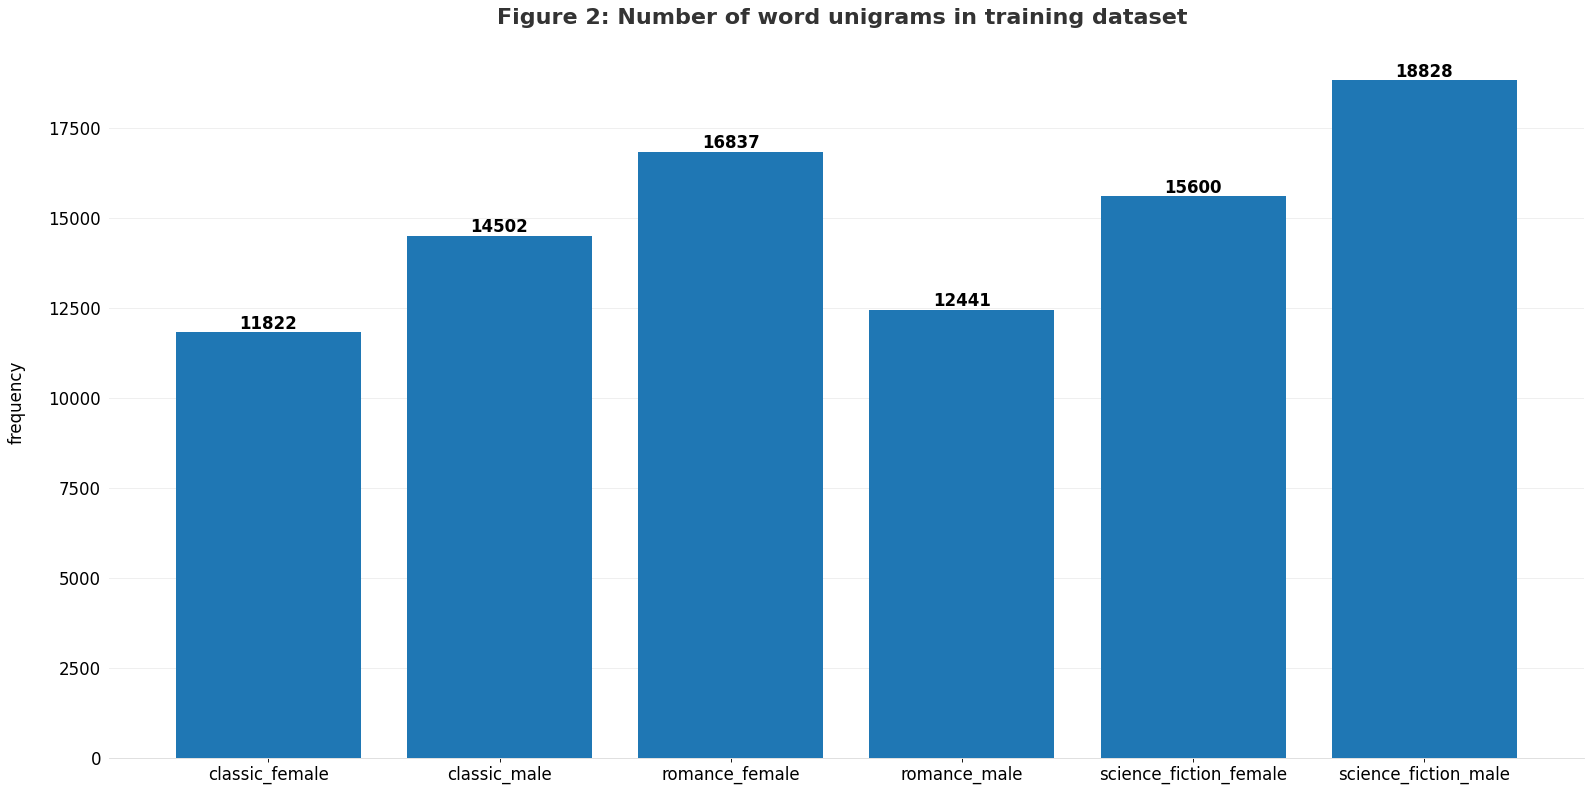

In [ ]:
# Creating plot for unigram frequencies
fig,ax = plt.subplots(figsize=(20,10), dpi=80)

bar_chart = ax.bar(x=categories,
       height = list_number_of_unigrams)

# Axes formatting and labelling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=True, left=False, labelsize=15)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_ylabel('frequency', labelpad=20, fontsize=15)
ax.set_title('Figure 2: Number of word unigrams in training dataset ', pad=20, fontsize=20,
             color='#333333', weight='bold')

for bar in bar_chart:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 100,
      round(bar.get_height(), 4),
      horizontalalignment='center',
      color = 'black',
      weight='bold',
      size = 15)

plt.tight_layout()
plt.savefig(filePath+'frequency_unigrams.pdf', format ='pdf')

In [ ]:
# Pairwise Jaccard similarities for the vocabularies of all classes

# Defining function for calculating Jaccard similarity
def jaccard_sim(vocab_1, vocab_2):
    return len(vocab_1.intersection(vocab_2)) / len(vocab_1.union(vocab_2))

jacc_unigrams = defaultdict(Counter)

# Initialise and fill matrix
for l_1 in categories:
    for l_2 in categories:
        jacc_unigrams[l_1][l_2]=jaccard_sim(set(vocab_unigrams[l_1]), set(vocab_unigrams[l_2]))

# Store and display tables
df_jaccard_unigram = pd.DataFrame.from_dict(jacc_unigrams, orient='index',
                                            columns=categories).reindex(index=categories)
df_jaccard_unigram.to_latex(buf = filePath+'jaccard_uni', bold_rows = True,
                            caption='Jaccard similarity unigrams', label='jaccard_uni')
print('Pairwise Jaccard similarity for word unigrams:\n')
display(df_jaccard_unigram)


Pairwise Jaccard similarity for word unigrams:



,classic_female,classic_male,romance_female,romance_male,science_fiction_female,science_fiction_male
classic_female,1.000000,0.714025,0.658411,0.704102,0.679549,0.609431
classic_male,0.714025,1.000000,0.743477,0.698374,0.754196,0.721502
romance_female,0.658411,0.743477,1.000000,0.705581,0.775716,0.780935
romance_male,0.704102,0.698374,0.705581,1.000000,0.701724,0.633272
science_fiction_female,0.679549,0.754196,0.775716,0.701724,1.000000,0.778490
science_fiction_male,0.609431,0.721502,0.780935,0.633272,0.778490,1.000000


# Naive Bayes Classifier
This section is about training and evaluating the NB classifier on the six-label imbalanced dataset. Steps include:
- Setting up model architecture
- Training and evaluating NB only with smoothing
- Obtaining classification reports for random baselines
- Training and evaluating NB with smoothing and feature selection

### Model with smoothing but **without** feature selection


In [ ]:
# Get list of unique unigrams
set_list = list()

for cat in categories:
    all_keys = set(vocab_unigrams[cat])
    set_list.append(all_keys)

unique_words_unigrams = set().union(*set_list)

print('The number of unique unigrams in the training set is: {}'.format(len(unique_words_unigrams)))


The number of unique unigrams in the training set is: 20729


In [ ]:
# Naive bayes with smoothing

# Train the classifier P(w|c_i)
def naive_bayes_smoothing(vocabulary, cat, smoothing_alpha):

    probabilities = dict()

    for c in cat:
        probabilities[c] = dict()
        for word in unique_words_unigrams:
            if vocabulary[c][word]>0:
                probabilities[c][word]= vocabulary[c][word]
            else:
                probabilities[c][word]= smoothing_alpha
        total = sum(probabilities[c].values())
        probabilities[c]={word: probabilities[c][word]/total for word in probabilities[c]}

    return probabilities

In [ ]:
# Estimate P(cat), the probability of class cat, based on the class distribution in the train set
prob_class = dict()
for cat in categories:
    prob_class[cat] = len(train_data[train_data.true_label==cat])/len(train_data)
print(prob_class)

{'classic_female': 0.031104846614336518, 'classic_male': 0.029440974669291273, 'romance_female': 0.5697327598078528, 'romance_male': 0.05051722601602307, 'science_fiction_female': 0.09294029016501008, 'science_fiction_male': 0.22626390272748628}


In [ ]:
# Algorithm for predicting the labels
def get_nb_predictions(categories, test_data, probabilities, prob_class):

    # Initialize lists for storing ground truth labels and predictions
    labels = list()
    predictions = list()

    # Loop over categories
    for c_i in categories:

        # Loop over test reviews
        for rev in test_data[test_data.true_label==c_i].without_stops:

            # Store ground truth
            labels.append(c_i)

            # For each review, calculate scores for each of the categories
            scores = {'classic_female': 0, 'classic_male': 0, 'romance_female':0, 'romance_male':0,
                      'science_fiction_female':0, 'science_fiction_male':0}
            for word in rev:
                if word in probabilities[c_i]:
                    scores["classic_female"] += np.log(probabilities["classic_female"][word])
                    scores["classic_male"] += np.log(probabilities["classic_male"][word])
                    scores["romance_female"] += np.log(probabilities["romance_female"][word])
                    scores["romance_male"] += np.log(probabilities["romance_male"][word])
                    scores["science_fiction_female"] += np.log(probabilities["science_fiction_female"][word])
                    scores["science_fiction_male"] += np.log(probabilities["science_fiction_male"][word])

            # Class imbalance
            scores["classic_female"] += scores["classic_female"] + np.log(prob_class["classic_female"])
            scores["classic_male"] += scores["classic_male"] + np.log(prob_class["classic_male"])
            scores["romance_female"] += scores["romance_female"] + np.log(prob_class["romance_female"])
            scores["romance_male"] += scores["romance_male"] + np.log(prob_class["romance_male"])
            scores["science_fiction_female"] += scores["science_fiction_female"] + np.log(prob_class["science_fiction_female"])
            scores["science_fiction_male"] += scores["science_fiction_male"] + np.log(prob_class["science_fiction_male"])

            # Use highest score for prediction
            predictions.append(max(scores.items(), key=operator.itemgetter(1))[0])

    return labels, predictions

In [ ]:
# Hyperparameter tuning of alpha

alpha_parameter = [0.0000000001]+[x * 0.05 for x in range(1, 21)]

macro_f1_dict = dict()

for a in alpha_parameter:

    # Train
    probs = naive_bayes_smoothing(vocab_unigrams, categories, a)

    # Get predictions on dev set
    labels, predictions = get_nb_predictions(categories, dev_data, probs, prob_class)

    # Calculate and store macro F1 on test set
    macro_f1_dict[a] = f1_score(labels, predictions, average="macro")

In [ ]:
best_param, worst_param = max(macro_f1_dict, key=macro_f1_dict.get), min(macro_f1_dict, key=macro_f1_dict.get)
best_f1, worst_f1 = max(macro_f1_dict.values()), min(macro_f1_dict.values())

print(f"Smoothing parameter {best_param} produces the HIGHEST macro F1 on the dev set: {best_f1}")
print(f"Smoothing parameter {worst_param} produces the LOWEST macro F1 on the dev set: {worst_f1}")
print(f"The difference between the highest and lowest macro F1 is {best_f1-worst_f1}.")

Smoothing parameter 0.05 produces the HIGHEST macro F1 on the dev set: 0.39861027183650505
Smoothing parameter 0.55 produces the LOWEST macro F1 on the dev set: 0.39632835757990126
The difference between the highest and lowest macro F1 is 0.0022819142566037898.


In [ ]:
# Evalutating model with tuned hyperparameter
smoothing_alpha = 0.05

# Train
probs = naive_bayes_smoothing(vocab_unigrams, categories, smoothing_alpha)

# Get predictions on test set
labels, predictions = get_nb_predictions(categories, test_data, probs, prob_class)

print(classification_report(labels, predictions, digits = 4))

                        precision    recall  f1-score   support

        classic_female     0.2248    0.3594    0.2766      2318
          classic_male     0.3394    0.3356    0.3375      2175
        romance_female     0.8026    0.8156    0.8091     42007
          romance_male     0.1098    0.0958    0.1023      4218
science_fiction_female     0.3410    0.3682    0.3541      8568
  science_fiction_male     0.6476    0.5606    0.6009     16278

              accuracy                         0.6419     75564
             macro avg     0.4109    0.4225    0.4134     75564
          weighted avg     0.6471    0.6419    0.6433     75564



In [ ]:
# Initialize confusion matrix
c_matrix = defaultdict(Counter)
id2label={0:'classic_female', 1:'classic_male', 2:'romance_female', 3:'romance_male',
          4:'science_fiction_female', 5:'science_fiction_male'}

# Fill confusion matrix
for t, p in zip(labels, predictions):
    c_matrix[t][p] += 1

# Display confusion matrix
pd.DataFrame.from_dict(c_matrix, orient='index', columns=categories).reindex(index=categories)

,classic_female,classic_male,romance_female,romance_male,science_fiction_female,science_fiction_male
classic_female,833,525,546,22,188,204
classic_male,758,730,309,15,74,289
romance_female,881,170,34261,3011,2143,1541
romance_male,174,83,3030,404,261,266
science_fiction_female,400,166,2069,112,3155,2666
science_fiction_male,659,477,2472,114,3431,9125


## Simple random baselines

In [ ]:
# Baseline for randomly predicting the labels according to their probability in the entire dataset
number_class_pred = list()

# Get number of reviews in each class
for i in dict_plot_cat.values():
    number_class_pred.append(round(i*len(predictions), 0))
print(number_class_pred)

[2270.0, 2186.0, 43317.0, 3873.0, 7154.0, 16763.0]


In [ ]:
sum(number_class_pred)-len(predictions) # one observation too little

-1.0

In [ ]:
# Generating labels according to their frequency in the dataset
dict_class_prob_pred = dict()

# Create list of lables for each category and store them in dict
for l, j in zip(categories, number_class_pred):
    dict_class_prob_pred[l]=[l]*int(j)

# Create one list out of all sublists
new_pred_class_prob = list()

for i in dict_class_prob_pred.values():
    new_pred_class_prob.append(i)

# Flat list:
new_pred_class_prob = [item for sublist in new_pred_class_prob for item in sublist]

In [ ]:
# Add label "science_fiction_female" because it was close to be rounded up and otherwise one label too little (see Distribution plot)
new_pred_class_prob += ['science_fiction_female']


In [ ]:
# Randomise list
baseline_class_prob = random.sample(new_pred_class_prob, len(new_pred_class_prob))
len(baseline_class_prob)

75564

In [ ]:
print('BASELINE FOR RANDOMLY PREDICTING CLASSES ACCORDING TO THEIR PROBABILITY IN THE ENTIRE DATASET\n')
print(classification_report(labels, baseline_class_prob, zero_division=0, digits = 4))

# Store results
report_random = classification_report(labels, baseline_class_prob, digits = 4, output_dict=True)
df_report_random = pd.DataFrame(report_random).transpose()
df_report_random.to_latex(buf = filePath+'random_report', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report Radnom baseline, unbalanced dataset', label='report_random')



BASELINE FOR RANDOMLY PREDICTING CLASSES ACCORDING TO THEIR PROBABILITY IN THE ENTIRE DATASET

                        precision    recall  f1-score   support

        classic_female     0.0335    0.0328    0.0331      2318
          classic_male     0.0265    0.0267    0.0266      2175
        romance_female     0.5538    0.5711    0.5623     42007
          romance_male     0.0491    0.0450    0.0470      4218
science_fiction_female     0.1124    0.0938    0.1023      8568
  science_fiction_male     0.2148    0.2212    0.2179     16278

              accuracy                         0.3800     75564
             macro avg     0.1650    0.1651    0.1649     75564
          weighted avg     0.3714    0.3800    0.3755     75564



In [ ]:
# Baseline for correctly predicting genre but randomly predicting gender (according to probability within genre)

baseline_corr_genre_random = np.array(labels)

# Get index of labels in correct label list for each genre and then shuffle within book genre
for substr in ['classic', 'romance', 'science']:
    indx_to_shuffle = np.where([substr in x for x in baseline_corr_genre_random])
    print(indx_to_shuffle)
    baseline_corr_genre_random[indx_to_shuffle] = np.random.permutation(baseline_corr_genre_random[indx_to_shuffle])

(array([   0,    1,    2, ..., 4490, 4491, 4492]),)
(array([ 4493,  4494,  4495, ..., 50715, 50716, 50717]),)
(array([50718, 50719, 50720, ..., 75561, 75562, 75563]),)


In [ ]:
print('BASELINE FOR CORRECTLY PREDICTING BOOK GENRE BUT RANDOMLY PREDICTING GENDER WITHIN GENRE\n')
print(classification_report(labels, baseline_corr_genre_random, zero_division=0, digits = 4))

# Store results
report_random_genre = classification_report(labels, baseline_corr_genre_random, digits = 4, output_dict=True)
df_report_random_genre = pd.DataFrame(report_random_genre).transpose()
df_report_random_genre.to_latex(buf = filePath+'random_report_genre',
                                header = ['Precision', 'Recall', 'F1-score', 'Support'],
                                bold_rows = False, float_format="%.4f",
                                caption='Classification Report correct genre random gender, imbalanced dataset',
                                label='report_random')



BASELINE FOR CORRECTLY PREDICTING BOOK GENRE BUT RANDOMLY PREDICTING GENDER WITHIN GENRE

                        precision    recall  f1-score   support

        classic_female     0.5073    0.5073    0.5073      2318
          classic_male     0.4749    0.4749    0.4749      2175
        romance_female     0.9085    0.9085    0.9085     42007
          romance_male     0.0891    0.0891    0.0891      4218
science_fiction_female     0.3424    0.3424    0.3424      8568
  science_fiction_male     0.6539    0.6539    0.6539     16278

              accuracy                         0.7190     75564
             macro avg     0.4960    0.4960    0.4960     75564
          weighted avg     0.7190    0.7190    0.7190     75564



## Naive Bayes with smoothing **and feature selection**

In [ ]:
# Mutual information

# Create dictionary which counts the number of reviews a word appears in
# (ignoring if it appears more than once in a review)

n_reviews = defaultdict(Counter)

for i,j in zip(train_data.without_stops, train_data.true_label):
    n_reviews[j].update(set(i))

In [ ]:
# Get number of reviews per category
n_total = dict()

for cat in categories:
    n_total[cat]= len(train_data[train_data.true_label == cat])
n_total

{'classic_female': 19199,
 'classic_male': 18172,
 'romance_female': 351659,
 'romance_male': 31181,
 'science_fiction_female': 57366,
 'science_fiction_male': 139658}

In [ ]:
def mutual_info(word, n_reviews, n_total):

    # Create a matrix: for each class (row), how many tweets did it appear in (col1) and not appear in (col2)
    count_matrix = np.array([[n_reviews["classic_female"][word], n_total["classic_female"]
                              - n_reviews["classic_female"][word]],
                             [n_reviews["classic_male"][word], n_total["classic_male"]
                              - n_reviews["classic_male"][word]],
                             [n_reviews["romance_female"][word], n_total["romance_female"]
                              - n_reviews["romance_female"][word]],
                             [n_reviews["romance_male"][word], n_total["romance_male"]
                              - n_reviews["romance_male"][word]],
                             [n_reviews["science_fiction_female"][word], n_total["science_fiction_female"]
                              - n_reviews["science_fiction_female"][word]],
                             [n_reviews["science_fiction_male"][word], n_total["science_fiction_male"]
                              - n_reviews["science_fiction_male"][word]]])

    # Store the sum of that matrix --> total number of tweets in the training set
    N = count_matrix.sum()

    # Initialise the value we will return
    out = 0

    # Iterate through columns and rows
    for col in range(2):
        for row in range(6):

            if count_matrix[row, col]!= 0:
                out += count_matrix[row, col] * np.log2((N*count_matrix[row, col]) / (count_matrix[row, :].sum() * count_matrix[:, col].sum()))

            # Do not increase MI score if no observation in training data
            else:
                out +=0

    return (1/N) * out

In [ ]:
mutual_info_values = sorted([(mutual_info(w, n_reviews, n_total), w) for w in unique_words_unigrams], reverse=True)

print('30 overall most informative features:', [w for mi, w in mutual_info_values][:30])

30 overall most informative features: ['love', 'science', 'sci', 'fi', 'hot', 'fiction', 'space', 'heart', 'action', 'series', 'universe', 'chemistry', 'relationship', 'classic', 'human', 'honest', 'novel', 'world', 'voluntarily', 'wait', 'war', 'interesting', 'technology', 'family', 'beautiful', 'amazing', 'planet', 'sex', 'story', 'earth']


In [ ]:
len(mutual_info_values)

20729

In [ ]:
# Function for training the classifier P(w|c_i) with feature selection
def naive_bayes(unique_words_unigrams, vocabulary, cat, smoothing_alpha, top_n, mutual_info_values):

    probabilities = dict()

    top_mu_info = dict([(t[1], t[0]) for t in mutual_info_values[ :top_n]]) #feature selection

    for c in cat:
        probabilities[c] = dict()
        for word in unique_words_unigrams:
            if word in top_mu_info:
                if vocabulary[c][word]>0:
                    probabilities[c][word]= vocabulary[c][word]
                else:
                    probabilities[c][word]= smoothing_alpha
        total = sum(probabilities[c].values())
        probabilities[c]={word: probabilities[c][word]/total for word in probabilities[c]}

    return probabilities

In [ ]:
# Hyperparameter tuning for smoothing alpha and for top_n features
top_n_parameter = [1000, 2000, 5000, 10000, 15000, 18000, 20000, 20729]

alpha_parameter = [0.0000000001]+[x * 0.05 for x in range(1, 21)] #maybe later more.

macro_f1_dict = dict()

for n in top_n_parameter:
    for a in alpha_parameter:

        # Train
        probs = naive_bayes(unique_words_unigrams, vocab_unigrams, categories, a, n, mutual_info_values)

        # Get predictions on dev set
        labels, predictions = get_nb_predictions(categories, dev_data, probs, prob_class)

        # Calculate and store macro F1 on test set
        macro_f1_dict[str(n)+'_'+str(a)] = f1_score(labels, predictions, average="macro")

In [ ]:
best_param, worst_param = max(macro_f1_dict, key=macro_f1_dict.get), min(macro_f1_dict, key=macro_f1_dict.get)
best_f1, worst_f1 = max(macro_f1_dict.values()), min(macro_f1_dict.values())

print(f"Smoothing parameter {best_param} produces the HIGHEST macro F1 on the dev set: {best_f1}")
print(f"Smoothing parameter {worst_param} produces the LOWEST macro F1 on the dev set: {worst_f1}")
print(f"The difference between the highest and lowest macro F1 is {best_f1-worst_f1}.")

Smoothing parameter 20000_0.05 produces the HIGHEST macro F1 on the dev set: 0.3987459740009238
Smoothing parameter 1000_1e-10 produces the LOWEST macro F1 on the dev set: 0.37774994841822673
The difference between the highest and lowest macro F1 is 0.020996025582697087.


In [ ]:
# Train and evaluate on test set
top_n = 20000
smoothing_alpha = 0.05

# Train
probs = naive_bayes(unique_words_unigrams, vocab_unigrams, categories, smoothing_alpha, top_n,  mutual_info_values)

# Get predictions on test set
labels, predictions = get_nb_predictions(categories, test_data, probs, prob_class)

# Get classification report
report_nb = classification_report(labels, predictions, digits = 4, output_dict=True)
df_report_nb = pd.DataFrame(report_nb).transpose()
df_report_nb.to_latex(buf = filePath+'nb_report', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, unbalanced dataset', label='report_nb')
print(classification_report(labels, predictions, digits = 4))

                        precision    recall  f1-score   support

        classic_female     0.2251    0.3594    0.2768      2318
          classic_male     0.3386    0.3361    0.3373      2175
        romance_female     0.8026    0.8156    0.8090     42007
          romance_male     0.1104    0.0963    0.1028      4218
science_fiction_female     0.3408    0.3681    0.3539      8568
  science_fiction_male     0.6475    0.5604    0.6008     16278

              accuracy                         0.6419     75564
             macro avg     0.4108    0.4226    0.4135     75564
          weighted avg     0.6471    0.6419    0.6433     75564



In [ ]:
# Initialize confusion matrix
c_matrix = defaultdict(Counter)
id2label={0:'classic_female', 1:'classic_male', 2:'romance_female', 3:'romance_male', 4:'science_fiction_female', 5:'science_fiction_male'}

# Fill confusion matrix
for t, p in zip(labels, predictions):
    c_matrix[t][p] += 1

# Display confusion matrix
df_confu_nb = pd.DataFrame.from_dict(c_matrix, orient='index', columns=categories).reindex(index=categories)
display(df_confu_nb)

# Store results as latex file
df_confu_nb.to_latex(buf = filePath+'confu_nb', bold_rows = True,
                     caption='Confusion Matrix NB classifier, unbalanced dataset')

,classic_female,classic_male,romance_female,romance_male,science_fiction_female,science_fiction_male
classic_female,833,525,546,22,188,204
classic_male,757,731,310,14,74,289
romance_female,879,173,34259,3012,2143,1541
romance_male,174,83,3028,406,261,266
science_fiction_female,399,168,2070,112,3154,2665
science_fiction_male,659,479,2471,113,3434,9122


In [ ]:
# Function to calculate how often the classifier correctly predicted the gender, irrespective of book genre
def correct_gender_pred(df_confu, test_dataframe):

    #Get number of correct female and male predictions
    sum_female_correct = df_confu.iloc[[0,2,4],[0,2,4]].values.sum()
    sum_male_correct = df_confu.iloc[[1,3,5],[1,3,5]].values.sum()
    length_dataset = len(test_dataframe)

    # Get percentage of correctly predicted gender labels
    percent_corr_pred = round(100*((sum_female_correct + sum_male_correct)/length_dataset),2)

    # Get percentage of labels that contain "female"
    percent_female = round(100*(len(test_dataframe[test_dataframe.true_label.str.contains('female')])
                                /len(test_dataframe)), 2)

    # Compare test set to predictions
    print('The percentage of women in the dataset is: {}%.'.format(percent_female))
    print('The percentage of correctly classified gender independent of category is: {}%.'.format(percent_corr_pred))
    print('This gives a difference of {} percentage points.'.format(abs(round(percent_corr_pred-percent_female,2))))

    return percent_corr_pred


In [ ]:
corr_gender_nb = correct_gender_pred(df_confu_nb, test_data)

The percentage of women in the dataset is: 70.0%.
The percentage of correctly classified gender independent of category is: 74.07%.
This gives a difference of 4.07 percentage points.


# LSTM classifier

This section implements the LSTM classifier. This includes:
- Setting up the architecture
- Doing hyperparameter tuning
- Train and evaluate on test set

## Setting up LSTM architecture

In [ ]:
# Define dataset class
class LSTMDataset(Dataset):
    def __init__(self, data, w2id):

        # Encode reviews
        self.reviews = list(data.cleaned_text.apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))

        # Store labels
        self.labels = list(data.label_id)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        return review, label

In [ ]:
# Define collate function
def lstm_collate(batch):

    # Store batch size
    batch_size = len(batch)

    # Separate reviews and labels
    reviews = [r for r, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long() # .long means that the dtype is now int64

    # Store length of longest review in batch
    max_len = max(len(r) for r in reviews)

    # Create padded review tensors
    reviews_pad = torch.zeros((batch_size, max_len)).long()
    for i, r in enumerate(reviews):
        reviews_pad[i, :len(r)] = torch.tensor(r)

    return reviews_pad, labels

In [ ]:
# Create dictionary for word look-up
word_counter = Counter([w for r in train_data.cleaned_text for w in r])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [ ]:
# Create datasets
train_dataset = LSTMDataset(train_data, w2id)
dev_dataset = LSTMDataset(dev_data, w2id)
test_dataset = LSTMDataset(test_data, w2id)

In [ ]:
# Create matrix of pretrained embeddings
fasttext_emb = torch.tensor(np.array([fasttext_vecs[id2w[i]] for i in range(2, len(id2w) + 2)])).float()
fasttext_emb = torch.cat((torch.zeros((1, 300)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)

## Hyperparameter tuning LSTM

In [ ]:
macro_f1_dict_lstm = dict()

b_sizes = [16, 32, 64, 128]
l_rate = [0.01, 0.0015, 0.05, 0.1, 0.15]
d_rate = [0.1, 0.2]


for ba in b_sizes:
  for l in l_rate:
    for d in d_rate:

      # Define LSTM classifier
      class LSTMClassifier(nn.Module):

          def __init__(self, pretrained_emb, hidden_dim, output_dim):

              # Define network layers
              super(LSTMClassifier, self).__init__()
              self.embedding = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=0)
              self.lstm = nn.LSTM(pretrained_emb.shape[1], hidden_dim, batch_first=True)
              self.linear = nn.Linear(hidden_dim, output_dim)

              # Define dropout
              self.dropout = nn.Dropout(d)

          def forward(self, reviews):

              # Define flow of tensors through network
              emb = self.embedding(reviews)
              output, (hidden, cell) = self.lstm(self.dropout(emb))
              return self.linear(self.dropout(output[:, -1, :]))


      # Create data loaders
      batch_size = ba

      train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=lstm_collate, shuffle=True)
      dev_loader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=lstm_collate)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lstm_collate)

      # Initialize model
      model = LSTMClassifier(fasttext_emb, hidden_dim = 200, output_dim = 6)

      # Define optimizer and training objective
      optimizer = optim.Adam(model.parameters(), lr=l)
      criterion = nn.CrossEntropyLoss()

      # Define device and move model to CUDA if available
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      model = model.to(device)

      # Train model
      for epoch in range(1, 10):

          model.train()

          for i, b in enumerate(train_loader):

              # Perform forward pass
              optimizer.zero_grad()
              reviews, lbls = [t.to(device) for t in b]
              output = model(reviews)
              loss = criterion(output, lbls)

              # Perform backpropagation and update weights
              loss.backward()
              optimizer.step()

          # Evaluate model on development data
          if epoch % 1 == 0:
            model.eval()

            y_true = list()
            y_pred = list()

            with torch.no_grad():
                for b in dev_loader:
                    reviews, lbls = [t.to(device) for t in b]
                    output = model(reviews)
                    max_output = output.argmax(dim=1)
                    y_true.extend(lbls.tolist())
                    y_pred.extend(max_output.tolist())


            # Calculate and store macro F1 on test set
            macro_f1_dict_lstm[str(ba)+'_'+str(l)+'_'+str(d)+'_'+str(epoch)] = f1_score(y_true, y_pred, average="macro")

In [ ]:
best_param_lstm = max(macro_f1_dict_lstm, key=macro_f1_dict_lstm.get)
print(f"The parameters {best_param_lstm} produce the HIGHEST macro F1 on the dev set")

The parameters 16_0.0015_0.2_5 produce the HIGHEST macro F1 on the dev set


## LSTM with optimal hyperparameter

In [ ]:
# Define LSTM classifier
class LSTMClassifier(nn.Module):

    def __init__(self, pretrained_emb, hidden_dim, output_dim):

        # Define network layers
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=0)
        self.lstm = nn.LSTM(pretrained_emb.shape[1], hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

        # Define dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, reviews):

        # Define flow of tensors through network
        emb = self.embedding(reviews)
        output, (hidden, cell) = self.lstm(self.dropout(emb))
        return self.linear(self.dropout(output[:, -1, :]))

In [ ]:
# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=lstm_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=lstm_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lstm_collate)

In [ ]:
# Initialize model
model = LSTMClassifier(fasttext_emb, hidden_dim = 200, output_dim = 6)

In [ ]:
# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.0015)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Define device and move model to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Train model
for epoch in range(1, 6):

    model.train()

    for i, b in enumerate(tqdm(train_loader)):

        # Perform forward pass
        optimizer.zero_grad()
        reviews, lbls = [t.to(device) for t in b]
        output = model(reviews)
        loss = criterion(output, lbls)

        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()

    # Evaluate model on development data
    # Evaluate model every fifth epoch
    if epoch % 1 == 0:
      model.eval()

      y_true = list()
      y_pred = list()

      with torch.no_grad():
          for b in dev_loader: #change back to dev_loader!!!
              reviews, lbls = [t.to(device) for t in b]
              output = model(reviews)
              max_output = output.argmax(dim=1)
              y_true.extend(lbls.tolist())
              y_pred.extend(max_output.tolist())

      print('Development accuracy after {} epoch(s): {:.2f}'.format(epoch, accuracy_score(y_true, y_pred)))
      print('Macro F1 score after {} epoch(s): {:.2f}'.format(epoch, f1_score(y_true, y_pred, average="macro")))

  0%|          | 0/38578 [00:00<?, ?it/s]

Development accuracy after 1 epoch(s): 0.76
Macro F1 score after 1 epoch(s): 0.33


  0%|          | 0/38578 [00:00<?, ?it/s]

Development accuracy after 2 epoch(s): 0.76
Macro F1 score after 2 epoch(s): 0.37


  0%|          | 0/38578 [00:00<?, ?it/s]

Development accuracy after 3 epoch(s): 0.77
Macro F1 score after 3 epoch(s): 0.41


  0%|          | 0/38578 [00:00<?, ?it/s]

Development accuracy after 4 epoch(s): 0.77
Macro F1 score after 4 epoch(s): 0.40


  0%|          | 0/38578 [00:00<?, ?it/s]

Development accuracy after 5 epoch(s): 0.77
Macro F1 score after 5 epoch(s): 0.40


In [ ]:
# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        reviews, lbls = [t.to(device) for t in b]
        output = model(reviews)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))

Test accuracy: 0.73


In [ ]:
# Get classification report
report_lstm = classification_report(y_true, y_pred, digits = 4, output_dict=True)
df_report_lstm = pd.DataFrame(report_lstm).transpose()
df_report_lstm.to_latex(buf = filePath+'lstm_report', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report LSTM classifier, unbalanced dataset', label='report_lstm')

print(classification_report(y_true, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.3520    0.2632    0.3012      2318
           1     0.4083    0.3940    0.4010      2175
           2     0.7893    0.9594    0.8661     42007
           3     0.6667    0.0005    0.0009      4218
           4     0.5573    0.1095    0.1830      8568
           5     0.6389    0.7452    0.6880     16278

    accuracy                         0.7257     75564
   macro avg     0.5688    0.4120    0.4067     75564
weighted avg     0.6994    0.7257    0.6713     75564



In [ ]:
# Initialize confusion matrix
c_matrix = defaultdict(Counter)
id2label={0:'classic_female', 1:'classic_male', 2:'romance_female', 3:'romance_male',
          4:'science_fiction_female', 5:'science_fiction_male'}

# Fill confusion matrix
for t, p in zip(y_true, y_pred):
    c_matrix[id2label[t]][id2label[p]] += 1

# Display confusion matrix
df_confu_lstm = pd.DataFrame.from_dict(c_matrix, orient='index',
                                       columns=id2label.values()).reindex(index=id2label.values())
df_confu_lstm.fillna(0, inplace=True) # NaN values occur if there was no prediction for a specific label
display(df_confu_lstm)

# Store results as latex file
df_confu_lstm.to_latex(buf = filePath+'confu_lstm', bold_rows = True,
                       caption='Confusion Matrix LSTM classifier, unbalanced dataset')


,classic_female,classic_male,romance_female,romance_male,science_fiction_female,science_fiction_male
classic_female,610,570,785,0.0,18,335
classic_male,438,857,450,1.0,2,427
romance_female,157,47,40302,0.0,131,1370
romance_male,58,32,3876,2.0,20,230
science_fiction_female,198,165,2774,0.0,938,4493
science_fiction_male,272,428,2873,0.0,574,12131


In [ ]:
# Accuracy of correctly predicting gender irrespective of book genre
corr_gender_lstm = correct_gender_pred(df_confu_lstm, test_data)

The percentage of women in the dataset is: 70.0%.
The percentage of correctly classified gender independent of category is: 79.43%.
This gives a difference of 9.43 percentage points.


# Models with balanced datasets
This section implements the second data structure setup, i.e. obtaining three gender-specific balanced datasets and evaluate NB on them. Steps inlcude:
- Up- and downsampling
- Train-test split for the separate datasets
- Adjust model architecture of NB to two label classification task
- Training and evaluating NB classifiers on the separate datasets

## Balancing and splitting the dataset

In [ ]:
# Up- and Downsampling

# Splitting dataset by label
df_classic_female= df_reviews_sentences[df_reviews_sentences['true_label']=='classic_female']
df_classic_male= df_reviews_sentences[df_reviews_sentences['true_label']=='classic_male']
df_romance_female= df_reviews_sentences[df_reviews_sentences['true_label']=='romance_female']
df_romance_male = df_reviews_sentences[df_reviews_sentences['true_label']=='romance_male']
df_science_female = df_reviews_sentences[df_reviews_sentences['true_label']=='science_fiction_female']
df_science_male = df_reviews_sentences[df_reviews_sentences['true_label']=='science_fiction_male']

dict_len_dataset = {'classic_female': len(df_classic_female), 'classic_male':len(df_classic_male),
                    'romance_female':len(df_romance_female), 'romance_male': len(df_romance_male),
                    'science_fiction_female': len(df_science_female), 'science_fiction_male': len(df_science_male)}

length_shortest_df = dict_len_dataset[min(dict_len_dataset, key=dict_len_dataset.get)]
length_longest_df = dict_len_dataset[max(dict_len_dataset, key=dict_len_dataset.get)]
print('Shortest dataset: ', min(dict_len_dataset, key=dict_len_dataset.get))
print('Longest dataset: ', max(dict_len_dataset, key=dict_len_dataset.get))

# Upsampling
df_cl_f_up = resample(df_classic_female,random_state=42,n_samples= length_longest_df ,replace=True)
df_cl_m_up = resample(df_classic_male,random_state=42,n_samples= length_longest_df ,replace=True)
df_r_f_up = resample(df_romance_female,random_state=42,n_samples= length_longest_df ,replace=True)
df_r_m_up = resample(df_romance_male,random_state=42,n_samples= length_longest_df ,replace=True)
df_s_f_up = resample(df_science_female,random_state=42,n_samples= length_longest_df ,replace=True)
df_s_m_up = resample(df_science_male,random_state=42,n_samples= length_longest_df ,replace=True)

# Downsampling
df_cl_f_down = resample(df_classic_female,random_state=42,n_samples= length_shortest_df ,replace=True)
df_cl_m_down = resample(df_classic_male,random_state=42,n_samples= length_shortest_df ,replace=True)
df_r_f_down = resample(df_romance_female,random_state=42,n_samples= length_shortest_df ,replace=True)
df_r_m_down = resample(df_romance_male,random_state=42,n_samples= length_shortest_df ,replace=True)
df_s_f_down = resample(df_science_female,random_state=42,n_samples= length_shortest_df ,replace=True)
df_s_m_down = resample(df_science_male,random_state=42,n_samples= length_shortest_df ,replace=True)


print('Length of one downsampled dataset: {}'.format(len(df_cl_f_down)))
print('Length of one upsampled dataset: {}'.format(len(df_cl_f_up)))

Shortest dataset:  classic_male
Longest dataset:  romance_female
Length of one downsampled dataset: 22218
Length of one upsampled dataset: 440179


In [ ]:
# Generating separate genre-specific datasets for NB balanced

# Downsampled
df_classic = pd.concat([df_cl_m_down, df_cl_f_down])
df_romance = pd.concat([df_r_f_down, df_r_m_down])
df_science = pd.concat([df_s_f_down, df_s_m_down])

print(len(df_classic), len(df_romance), len(df_science))

# Upsampled
df_classic_up = pd.concat([df_cl_m_up, df_cl_f_up])
df_romance_up = pd.concat([df_r_f_up, df_r_m_up])
df_science_up = pd.concat([df_s_f_up, df_s_m_up])

print(len(df_classic_up), len(df_romance_up), len(df_science_up))

44436 44436 44436
880358 880358 880358


In [ ]:
# Split data into training, development, and test sets for two label dataset

# Upsampled
train_classic_up, dev_test_classic_up = train_test_split(df_classic_up, test_size=0.2,
                                                         stratify=df_classic_up['true_label'], random_state=0)
dev_classic_up, test_classic_up = train_test_split(dev_test_classic_up, test_size=0.5,
                                                   stratify=dev_test_classic_up['true_label'], random_state=0)

train_romance_up, dev_test_romance_up = train_test_split(df_romance_up, test_size=0.2,
                                                         stratify=df_romance_up['true_label'], random_state=0)
dev_romance_up, test_romance_up = train_test_split(dev_test_romance_up, test_size=0.5,
                                                   stratify=dev_test_romance_up['true_label'], random_state=0)

train_science_up, dev_test_science_up = train_test_split(df_science_up, test_size=0.2,
                                                         stratify=df_science_up['true_label'], random_state=0)
dev_science_up, test_science_up = train_test_split(dev_test_science_up, test_size=0.5,
                                                   stratify=dev_test_science_up['true_label'], random_state=0)

# Downsampled
train_classic, dev_test_classic = train_test_split(df_classic, test_size=0.2,
                                                   stratify=df_classic['true_label'], random_state=0)
dev_classic, test_classic = train_test_split(dev_test_classic, test_size=0.5,
                                             stratify=dev_test_classic['true_label'], random_state=0)

train_romance, dev_test_romance = train_test_split(df_romance, test_size=0.2,
                                                   stratify=df_romance['true_label'], random_state=0)
dev_romance, test_romance = train_test_split(dev_test_romance, test_size=0.5,
                                             stratify=dev_test_romance['true_label'], random_state=0)

train_science, dev_test_science = train_test_split(df_science, test_size=0.2,
                                                   stratify=df_science['true_label'], random_state=0)
dev_science, test_science = train_test_split(dev_test_science, test_size=0.5,
                                             stratify=dev_test_science['true_label'], random_state=0)

In [ ]:
print(len(train_classic_up), len(train_romance_up), len(train_science_up))

704286 704286 704286


In [ ]:
print(len(test_classic_up), len(test_romance_up), len(test_science_up))

88036 88036 88036


In [ ]:
print(len(dev_classic_up), len(dev_romance_up), len(dev_science_up))

88036 88036 88036


In [ ]:
print(len(train_classic), len(train_romance), len(train_science))

35548 35548 35548


## Adapting NB architecture to two-label datasets


In [ ]:
def get_nb_predictions_bi(cat_red, test_data, probabilities, prob_class):

    # Initialize lists for storing ground truth labels and predictions
    labels = list()
    predictions = list()

    # Loop over categories
    for c_i in cat_red:

        # Loop over test reviews
        for rev in test_data[test_data.true_label==c_i].without_stops:

            # Store ground truth
            labels.append(c_i)

            # For each review, calculate scores for each of the categories
            scores = {cat_red[0]: 0, cat_red[1]: 0}
            for word in rev:
                if word in probabilities[c_i]:
                    scores[cat_red[0]] += np.log(probabilities[cat_red[0]][word])
                    scores[cat_red[1]] += np.log(probabilities[cat_red[1]][word])

            # Class imbalance
            scores[cat_red[0]] += scores[cat_red[0]] + np.log(prob_class[cat_red[0]])
            scores[cat_red[1]] += scores[cat_red[1]] + np.log(prob_class[cat_red[1]])

            # Use highest score for prediction
            predictions.append(max(scores.items(), key=operator.itemgetter(1))[0])

    return labels, predictions

In [ ]:
# Define function to obtain vocabulary and  mutual info for a specific training dataset

def vocab_mutual_info_bi(train_df, cat_red):

    vocab_unigrams = defaultdict(Counter)

    # Create vocabulary
    for i,j in zip(train_df.without_stops, train_df.true_label):
        vocab_unigrams[j].update(i)

    # get list of unique unigrams
    set_list = list()

    for cat in cat_red:
        all_keys = set(vocab_unigrams[cat])
        set_list.append(all_keys)

    unique_words_unigrams = set().union(*set_list)


    # Mutual information

    # Create dictionary which counts the number of reviews a word appears in

    n_reviews = defaultdict(Counter)

    for i,j in zip(train_df.without_stops, train_df.true_label):
        n_reviews[j].update(set(i))

    n_total = dict() # number of reviews per category

    for cat in cat_red:
        n_total[cat]= len(train_df[train_df.true_label == cat])


    def mutual_info(word, n_reviews, n_total):

        # Create a matrix: for each class (row), how many tweets did it appear in (col1) and not appear in (col2)
        count_matrix = np.array([[n_reviews[cat_red[0]][word], n_total[cat_red[0]] - n_reviews[cat_red[0]][word]],
                                 [n_reviews[cat_red[1]][word], n_total[cat_red[1]] - n_reviews[cat_red[1]][word]]])

        # Store the sum of that matrix --> total number of tweets in the training set
        N = count_matrix.sum()

        # Initialise the value we will return
        out = 0

        # Iterate through columns and rows
        for col in range(2):
            for row in range(2):

                if count_matrix[row, col]!= 0:
                    out += count_matrix[row, col] * np.log2((N*count_matrix[row, col]) / (count_matrix[row, :].sum() * count_matrix[:, col].sum()))

                # Mutual information set to zero if word not in class
                else:
                    out =0

        return (1/N) * out

    mutual_info_values = sorted([(mutual_info(w, n_reviews, n_total), w) for w in unique_words_unigrams], reverse=True)

    # Class probabilities (not necessary)
    prob_class = dict()
    for cat in cat_red:
        prob_class[cat] = len(train_df[train_df.true_label==cat])/len(train_df)

    return mutual_info_values, vocab_unigrams, prob_class, unique_words_unigrams

In [ ]:
# Define function for hyperparamter tuning

top_n_parameter = [1000, 2000, 5000, 10000, 20000, 25000, 50000]

alpha_parameter = [0.0000000001]+[x * 0.05 for x in range(1, 21)]

def hyperparameter_tuning_bi_nb(unique_words_unigrams, dev_data, vocab, cat_red, mutual_info_values, prob_class):

    macro_f1_dict = dict()

    for n in top_n_parameter:
        for a in alpha_parameter:

            # Train
            probs = naive_bayes(unique_words_unigrams, vocab, cat_red, a, n, mutual_info_values)

            # Get predictions on dev set
            labels, predictions = get_nb_predictions_bi(cat_red, dev_data, probs, prob_class)

            # Calculate and store macro F1 on test set
            macro_f1_dict[str(n)+'_'+str(a)] = f1_score(labels, predictions, average="macro")

    best_param, worst_param = max(macro_f1_dict, key=macro_f1_dict.get), min(macro_f1_dict, key=macro_f1_dict.get)
    best_f1, worst_f1 = max(macro_f1_dict.values()), min(macro_f1_dict.values())

    print(f"\nSmoothing parameter {best_param} produces the HIGHEST macro F1 on the dev set: {best_f1}")
    print(f"Smoothing parameter {worst_param} produces the LOWEST macro F1 on the dev set: {worst_f1}")
    print(f"The difference between the highest and lowest macro F1 is {best_f1-worst_f1}.")
    return best_param

In [ ]:
# Define function to evaluate NB on test set
def eval_nb_bi(best_n, best_a, unique_words_unigrams, vocab_unigrams, cat_red, mutual_info_values,test_data, prob_class):

    # Hyperparameter
    top_n = best_n
    smoothing_alpha = best_a

    # Train
    probs = naive_bayes(unique_words_unigrams, vocab_unigrams, cat_red, smoothing_alpha, top_n,  mutual_info_values)

    # Get predictions on test set
    labels, predictions = get_nb_predictions_bi(cat_red, test_data, probs, prob_class)

    return labels,predictions

In [ ]:
# Define function to obtain confusion matrix
def confu_matrix(cat_red, y_true, y_pred):
    # Initialize confusion matrix
    c_matrix = defaultdict(Counter)

    # Fill confusion matrix
    for t, p in zip(y_true, y_pred):
        c_matrix[t][p] += 1

    # Create confusion matrix dataframe
    confu_df = pd.DataFrame.from_dict(c_matrix, orient='index', columns=cat_red).reindex(index=cat_red)

    return confu_df

## Train and evaluate NB on upsampled dataset

In [ ]:
# Get vocabulary, MI for each genre and perform hyperparameter tuning

# classic books
cat_red = ['classic_female', 'classic_male']
mutual_info_class, unigrams_class, prob_class_class, unique_class = vocab_mutual_info_bi(train_classic_up, cat_red)
hyperpara_class = hyperparameter_tuning_bi_nb(unique_class,dev_classic_up, unigrams_class,
                                              cat_red, mutual_info_class, prob_class_class)
print('Best hyperparameter classic reviews: {}'.format(hyperpara_class))

# romance books
cat_red = ['romance_female', 'romance_male']
mutual_info_romance, unigrams_romance, prob_class_romance, unique_romance = vocab_mutual_info_bi(train_romance_up, cat_red)
hyperpara_romance = hyperparameter_tuning_bi_nb(unique_romance, dev_romance_up, unigrams_romance,
                                                cat_red, mutual_info_romance, prob_class_romance)
print('Best hyperparameter romance reviews: {}'.format(hyperpara_romance))

# science fiction books
cat_red = ['science_fiction_female', 'science_fiction_male']
mutual_info_science, unigrams_science, prob_class_science, unique_science = vocab_mutual_info_bi(train_science_up, cat_red)
hyperpara_science = hyperparameter_tuning_bi_nb(unique_science, dev_science_up, unigrams_science,
                                                cat_red, mutual_info_science, prob_class_science)
print('Best hyperparameter science fiction reviews: {}'.format(hyperpara_science))


Smoothing parameter 20000_1e-10 produces the HIGHEST macro F1 on the dev set: 0.6812041500359263
Smoothing parameter 1000_1e-10 produces the LOWEST macro F1 on the dev set: 0.6308675868549272
The difference between the highest and lowest macro F1 is 0.050336563180999105.
Best hyperparameter classic reviews: 20000_1e-10

Smoothing parameter 20000_1e-10 produces the HIGHEST macro F1 on the dev set: 0.6071881531110748
Smoothing parameter 1000_1e-10 produces the LOWEST macro F1 on the dev set: 0.5784660123164005
The difference between the highest and lowest macro F1 is 0.028722140794674278.
Best hyperparameter romance reviews: 20000_1e-10

Smoothing parameter 20000_1e-10 produces the HIGHEST macro F1 on the dev set: 0.6596978438238084
Smoothing parameter 1000_1e-10 produces the LOWEST macro F1 on the dev set: 0.6459051621921943
The difference between the highest and lowest macro F1 is 0.013792681631614068.
Best hyperparameter science fiction reviews: 20000_1e-10


In [ ]:
# Get predictions and evaluations on test set

# classic books
n = 20000
a = 0.0000000001
labels_c, pred_c = eval_nb_bi(n, a, unique_class, unigrams_class, ['classic_female', 'classic_male'],
                              mutual_info_class, test_classic_up, prob_class_class)

confu_c = confu_matrix(['classic_female', 'classic_male'], labels_c, pred_c)
confu_c.to_latex(buf = filePath+'confu_c_up', bold_rows = True,
                 caption='Confusion Matrix NB classifier, balanced classic dataset (up)', label='confu_nb_c_up')

print('CLASSIFICATION RESULTS FOR CLASSIC REVIEWS DATASET: ')
print(classification_report(labels_c, pred_c, digits = 4))
report_nb_c = classification_report(labels_c, pred_c, digits = 4, output_dict=True)
df_report_nb_c = pd.DataFrame(report_nb_c).transpose()
df_report_nb_c.to_latex(buf = filePath+'nb_report_c_up', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, balanced classic dataset (up)',
                        label='report_nb_c_up')
print('\nConfusion matrix:')
display(confu_c)

# romance books
n = 20000
a = 0.0000000001
labels_r, pred_r = eval_nb_bi(n, a, unique_romance, unigrams_romance, ['romance_female', 'romance_male'],
                              mutual_info_romance, test_romance_up, prob_class_romance)

confu_r = confu_matrix(['romance_female', 'romance_male'], labels_r, pred_r)
confu_r.to_latex(buf = filePath+'confu_r_up', bold_rows = True,
                 caption='Confusion Matrix NB classifier, balanced romance dataset (up)', label='confu_nb_r_up')

print('CLASSIFICATION RESULTS FOR ROMANCE REVIEWS DATASET: ')
print(classification_report(labels_r, pred_r, digits = 4))
report_nb_r = classification_report(labels_r, pred_r, digits = 4, output_dict=True)
df_report_nb_r = pd.DataFrame(report_nb_r).transpose()
df_report_nb_r.to_latex(buf = filePath+'nb_report_r_up', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, balanced romance dataset (up)',
                        label='report_nb_r_up')
print('\nConfusion matrix:')
display(confu_r)

# science fiction books
n = 20000
a = 0.0000000001
labels_s, pred_s = eval_nb_bi(n, a, unique_science, unigrams_science,
                              ['science_fiction_female', 'science_fiction_male'], mutual_info_science,
                              test_science_up, prob_class_science)

confu_s = confu_matrix(['science_fiction_female', 'science_fiction_male'], labels_s, pred_s)
confu_s.to_latex(buf = filePath+'confu_s_up', bold_rows = True,
                 caption='Confusion Matrix NB classifier, balanced science dataset (up)', label='confu_nb_s_up')

print('CLASSIFICATION RESULTS FOR SCIENCE FICTION REVIEWS DATASET: ')
print(classification_report(labels_s, pred_s, digits = 4))
report_nb_s = classification_report(labels_s, pred_s, digits = 4, output_dict=True)
df_report_nb_s = pd.DataFrame(report_nb_s).transpose()
df_report_nb_s.to_latex(buf = filePath+'nb_report_s_up', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, balanced science dataset (up)',
                        label='report_nb_s_up')
print('\nConfusion matrix:')
display(confu_s)

CLASSIFICATION RESULTS FOR CLASSIC REVIEWS DATASET: 
                precision    recall  f1-score   support

classic_female     0.6440    0.8563    0.7351     44018
  classic_male     0.7857    0.5267    0.6306     44018

      accuracy                         0.6915     88036
     macro avg     0.7148    0.6915    0.6829     88036
  weighted avg     0.7148    0.6915    0.6829     88036


Confusion matrix:


,classic_female,classic_male
classic_female,37693,6325
classic_male,20835,23183


CLASSIFICATION RESULTS FOR ROMANCE REVIEWS DATASET: 
                precision    recall  f1-score   support

romance_female     0.6044    0.6221    0.6131     44018
  romance_male     0.6107    0.5928    0.6016     44018

      accuracy                         0.6075     88036
     macro avg     0.6076    0.6075    0.6074     88036
  weighted avg     0.6076    0.6075    0.6074     88036


Confusion matrix:


,romance_female,romance_male
romance_female,27385,16633
romance_male,17924,26094


CLASSIFICATION RESULTS FOR SCIENCE FICTION REVIEWS DATASET: 
                        precision    recall  f1-score   support

science_fiction_female     0.6349    0.7707    0.6963     44018
  science_fiction_male     0.7083    0.5569    0.6235     44018

              accuracy                         0.6638     88036
             macro avg     0.6716    0.6638    0.6599     88036
          weighted avg     0.6716    0.6638    0.6599     88036


Confusion matrix:


,science_fiction_female,science_fiction_male
science_fiction_female,33924,10094
science_fiction_male,19505,24513


## Train and evaluate NB on downsampled dataset

In [ ]:
# Get vocabulary, MI for each genre and perform hyperparameter tuning

# classic books
cat_red = ['classic_female', 'classic_male']
mutual_info_class, unigrams_class, prob_class_class, unique_class = vocab_mutual_info_bi(train_classic, cat_red)
hyperpara_class = hyperparameter_tuning_bi_nb(unique_class,dev_classic,
                                              unigrams_class, cat_red, mutual_info_class, prob_class_class)
print('Best hyperparameter classic reviews: {}'.format(hyperpara_class))

# romance books
cat_red = ['romance_female', 'romance_male']
mutual_info_romance, unigrams_romance, prob_class_romance, unique_romance = vocab_mutual_info_bi(train_romance, cat_red)
hyperpara_romance = hyperparameter_tuning_bi_nb(unique_romance, dev_romance,
                                                unigrams_romance, cat_red, mutual_info_romance, prob_class_romance)
print('Best hyperparameter romance reviews: {}'.format(hyperpara_romance))

# science fiction books
cat_red = ['science_fiction_female', 'science_fiction_male']
mutual_info_science, unigrams_science, prob_class_science, unique_science = vocab_mutual_info_bi(train_science, cat_red)
hyperpara_science = hyperparameter_tuning_bi_nb(unique_science, dev_science,
                                                unigrams_science, cat_red, mutual_info_science, prob_class_science)
print('Best hyperparameter science fiction reviews: {}'.format(hyperpara_science))


Smoothing parameter 20000_1e-10 produces the HIGHEST macro F1 on the dev set: 0.6738546131702535
Smoothing parameter 1000_1e-10 produces the LOWEST macro F1 on the dev set: 0.6273841949596113
The difference between the highest and lowest macro F1 is 0.04647041821064224.
Best hyperparameter classic reviews: 20000_1e-10

Smoothing parameter 20000_0.30000000000000004 produces the HIGHEST macro F1 on the dev set: 0.5865220927250757
Smoothing parameter 2000_1e-10 produces the LOWEST macro F1 on the dev set: 0.5717257736610499
The difference between the highest and lowest macro F1 is 0.014796319064025787.
Best hyperparameter romance reviews: 20000_0.30000000000000004

Smoothing parameter 5000_0.9500000000000001 produces the HIGHEST macro F1 on the dev set: 0.6545698560505684
Smoothing parameter 10000_1e-10 produces the LOWEST macro F1 on the dev set: 0.6427074129438116
The difference between the highest and lowest macro F1 is 0.01186244310675677.
Best hyperparameter science fiction reviews:

In [ ]:
# Get predictions on test set

# classic books
n = 20000
a = 0.0000000001
labels_c, pred_c = eval_nb_bi(n, a, unique_class, unigrams_class, ['classic_female', 'classic_male'],
                              mutual_info_class, test_classic, prob_class_class)

confu_c = confu_matrix(['classic_female', 'classic_male'], labels_c, pred_c)
confu_c.to_latex(buf = filePath+'confu_c_down', bold_rows = True,
                 caption='Confusion Matrix NB classifier, balanced classic dataset')

print('CLASSIFICATION RESULTS FOR CLASSIC REVIEWS DATASET: ')
print(classification_report(labels_c, pred_c, digits = 4))
report_nb_c = classification_report(labels_c, pred_c, digits = 4, output_dict=True)
df_report_nb_c = pd.DataFrame(report_nb_c).transpose()
df_report_nb_c.to_latex(buf = filePath+'nb_report_c', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, balanced classic dataset', label='report_nb_c')
print('\nConfusion matrix:')
display(confu_c)

# romance books
n = 20000
a = 0.3
labels_r, pred_r = eval_nb_bi(n, a, unique_romance, unigrams_romance, ['romance_female', 'romance_male'],
                              mutual_info_romance, test_romance, prob_class_romance)
confu_r = confu_matrix(['romance_female', 'romance_male'], labels_r, pred_r)
confu_r.to_latex(buf = filePath+'confu_r_down', bold_rows = True,
                 caption='Confusion Matrix NB classifier, balanced romance dataset')

print('CLASSIFICATION RESULTS FOR ROMANCE REVIEWS DATASET: ')
print(classification_report(labels_r, pred_r, digits = 4))
report_nb_r = classification_report(labels_r, pred_r, digits = 4, output_dict=True)
df_report_nb_r = pd.DataFrame(report_nb_r).transpose()
df_report_nb_r.to_latex(buf = filePath+'nb_report_r', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, balanced romance dataset', label='report_nb_r')
print('\nConfusion matrix:')
display(confu_r)

# science fiction books
n = 5000
a = 0.95
labels_s, pred_s = eval_nb_bi(n, a, unique_science, unigrams_science,
                              ['science_fiction_female', 'science_fiction_male'], mutual_info_science,
                              test_science, prob_class_science)

confu_s = confu_matrix(['science_fiction_female', 'science_fiction_male'], labels_s, pred_s)
confu_s.to_latex(buf = filePath+'confu_s_down', bold_rows = True,
                 caption='Confusion Matrix NB classifier, balanced science dataset')

print('CLASSIFICATION RESULTS FOR SCIENCE FICTION REVIEWS DATASET: ')
print(classification_report(labels_s, pred_s, digits = 4))
report_nb_s = classification_report(labels_s, pred_s, digits = 4, output_dict=True)
df_report_nb_s = pd.DataFrame(report_nb_s).transpose()
df_report_nb_s.to_latex(buf = filePath+'nb_report_s', header = ['Precision', 'Recall', 'F1-score', 'Support'],
                      bold_rows = False, float_format="%.4f",
                      caption='Classification Report NB classifier, balanced science dataset', label='report_nb_s')
print('\nConfusion matrix:')
display(confu_s)

CLASSIFICATION RESULTS FOR CLASSIC REVIEWS DATASET: 
                precision    recall  f1-score   support

classic_female     0.6422    0.8263    0.7227      2222
  classic_male     0.7565    0.5396    0.6299      2222

      accuracy                         0.6829      4444
     macro avg     0.6993    0.6829    0.6763      4444
  weighted avg     0.6993    0.6829    0.6763      4444


Confusion matrix:


,classic_female,classic_male
classic_female,1836,386
classic_male,1023,1199


CLASSIFICATION RESULTS FOR ROMANCE REVIEWS DATASET: 
                precision    recall  f1-score   support

romance_female     0.5891    0.6098    0.5993      2222
  romance_male     0.5956    0.5747    0.5850      2222

      accuracy                         0.5923      4444
     macro avg     0.5924    0.5923    0.5921      4444
  weighted avg     0.5924    0.5923    0.5921      4444


Confusion matrix:


,romance_female,romance_male
romance_female,1355,867
romance_male,945,1277


CLASSIFICATION RESULTS FOR SCIENCE FICTION REVIEWS DATASET: 
                        precision    recall  f1-score   support

science_fiction_female     0.6326    0.7408    0.6824      2222
  science_fiction_male     0.6873    0.5698    0.6230      2222

              accuracy                         0.6553      4444
             macro avg     0.6599    0.6553    0.6527      4444
          weighted avg     0.6599    0.6553    0.6527      4444


Confusion matrix:


,science_fiction_female,science_fiction_male
science_fiction_female,1646,576
science_fiction_male,956,1266
